In [1]:
from src.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from scipy.stats import norm

import os
import time as t

from Chempy.parameter import ModelParameters

%matplotlib inline

In [2]:
model = ModelTransfuser(14)
model = model.load('data/models/ModelTransfuser_best.pickle')
device = "cuda:9"

In [3]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y

# ---  Load in the validation data ---
path_test = os.getcwd() + '/data/Chempy_data/chempy_inference_TNG.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']

val_x, val_y = clean_data(val_x, val_y)

# convert to torch tensors
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

abundances = val_y

In [4]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000
N_stars = 200

mask = torch.zeros(14)
mask[6:] = 1

start = t.time()

inference = model.sample(abundances[:N_stars], condition_mask=mask, device=device, num_samples=simulations, temperature=1.2)

end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

100%|██████████| 200/200 [03:24<00:00,  1.02s/it]

Time to run 1000 simulations for 200 stars: 204.979 s


In [5]:
alpha_IMF_obs, log10_N_Ia_obs = inference[:,:,:2].cpu().T.detach().numpy()

alpha_IMF_obs = alpha_IMF_obs.T
log10_N_Ia_obs = log10_N_Ia_obs.T

/tmp/ipykernel_577395/943353855.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1725570624180/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  alpha_IMF_obs, log10_N_Ia_obs = inference[:,:,:2].cpu().T.detach().numpy()


In [6]:
from src.plot_functions import *

In [7]:
global_params = torch.tensor([[-2.3, -2.89], [0.3, 0.3]])

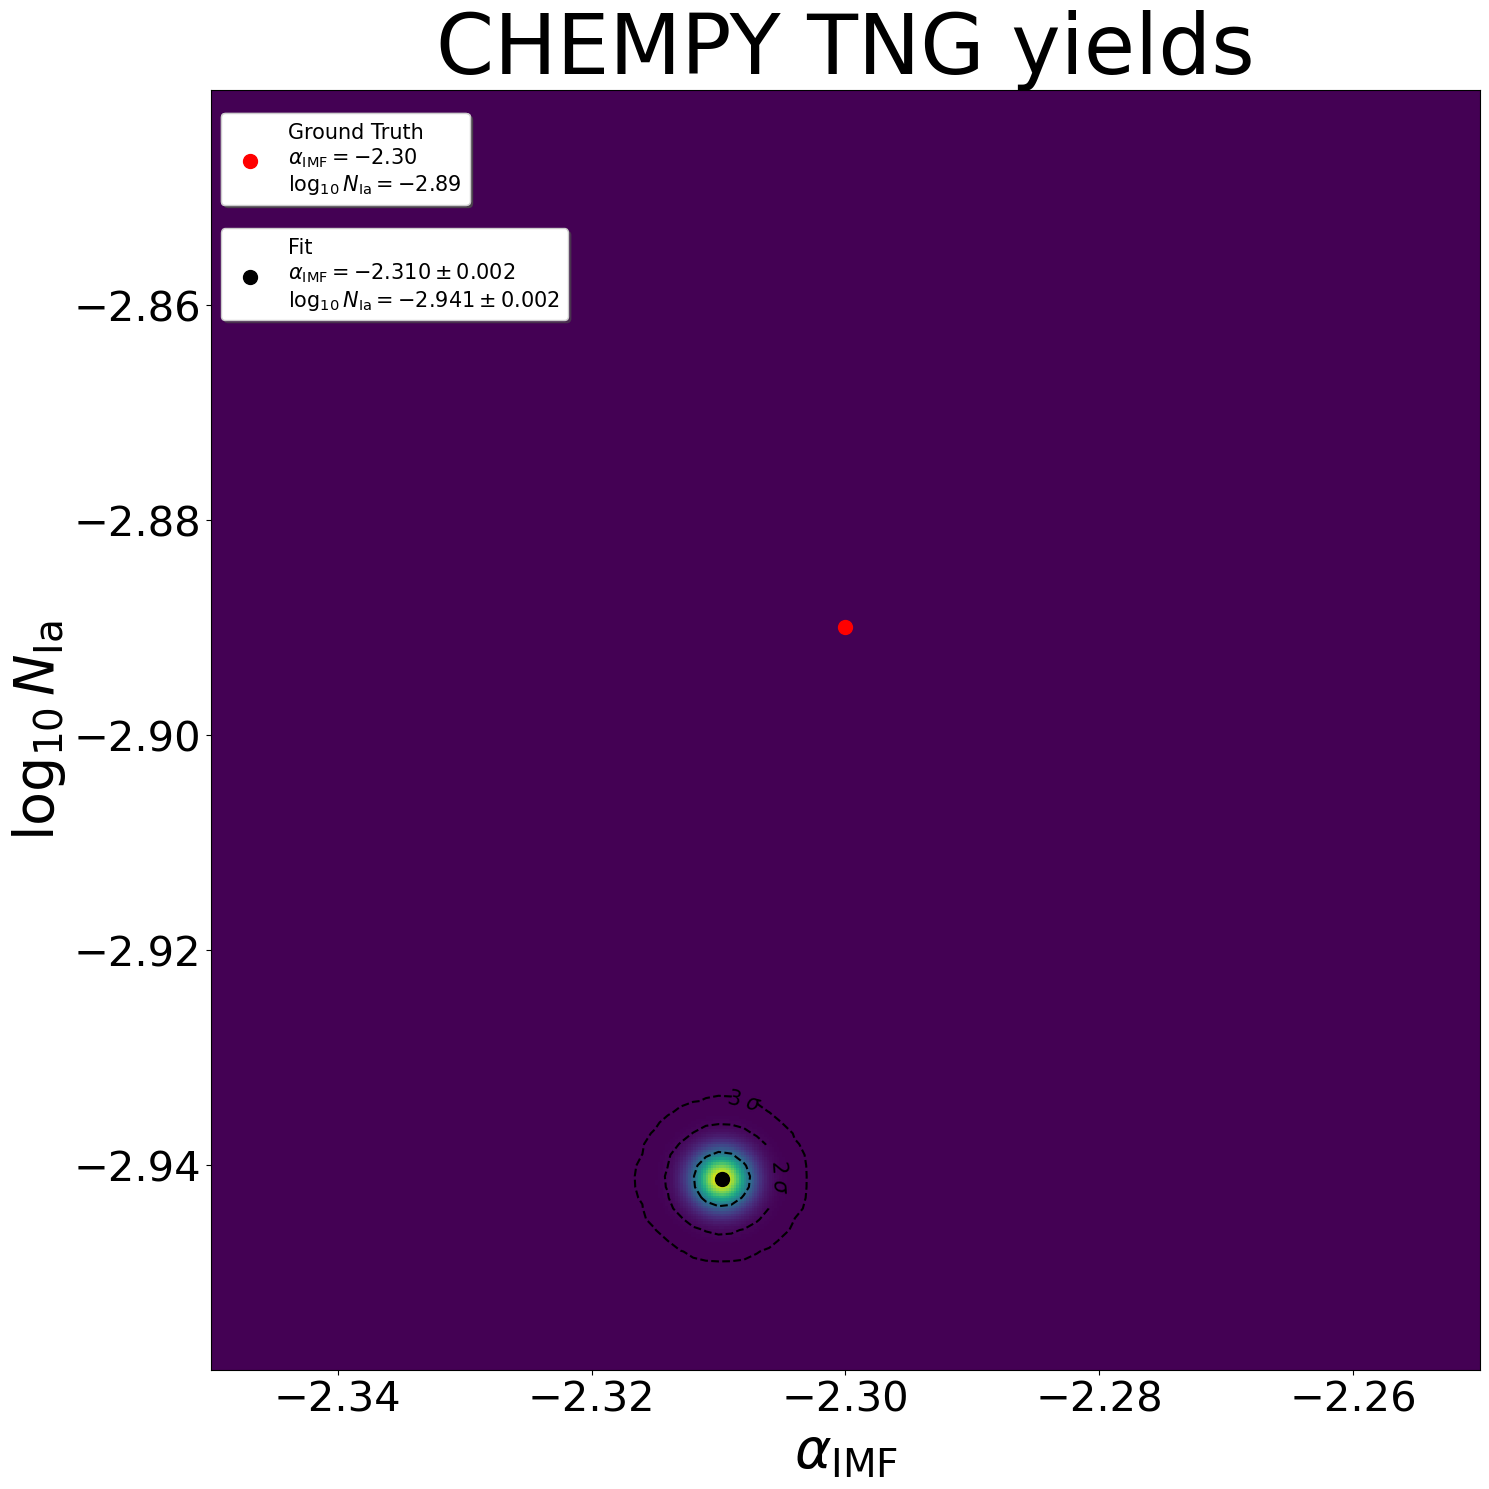

In [8]:
gaussian_posterior_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params.numpy(), title="CHEMPY TNG yields")

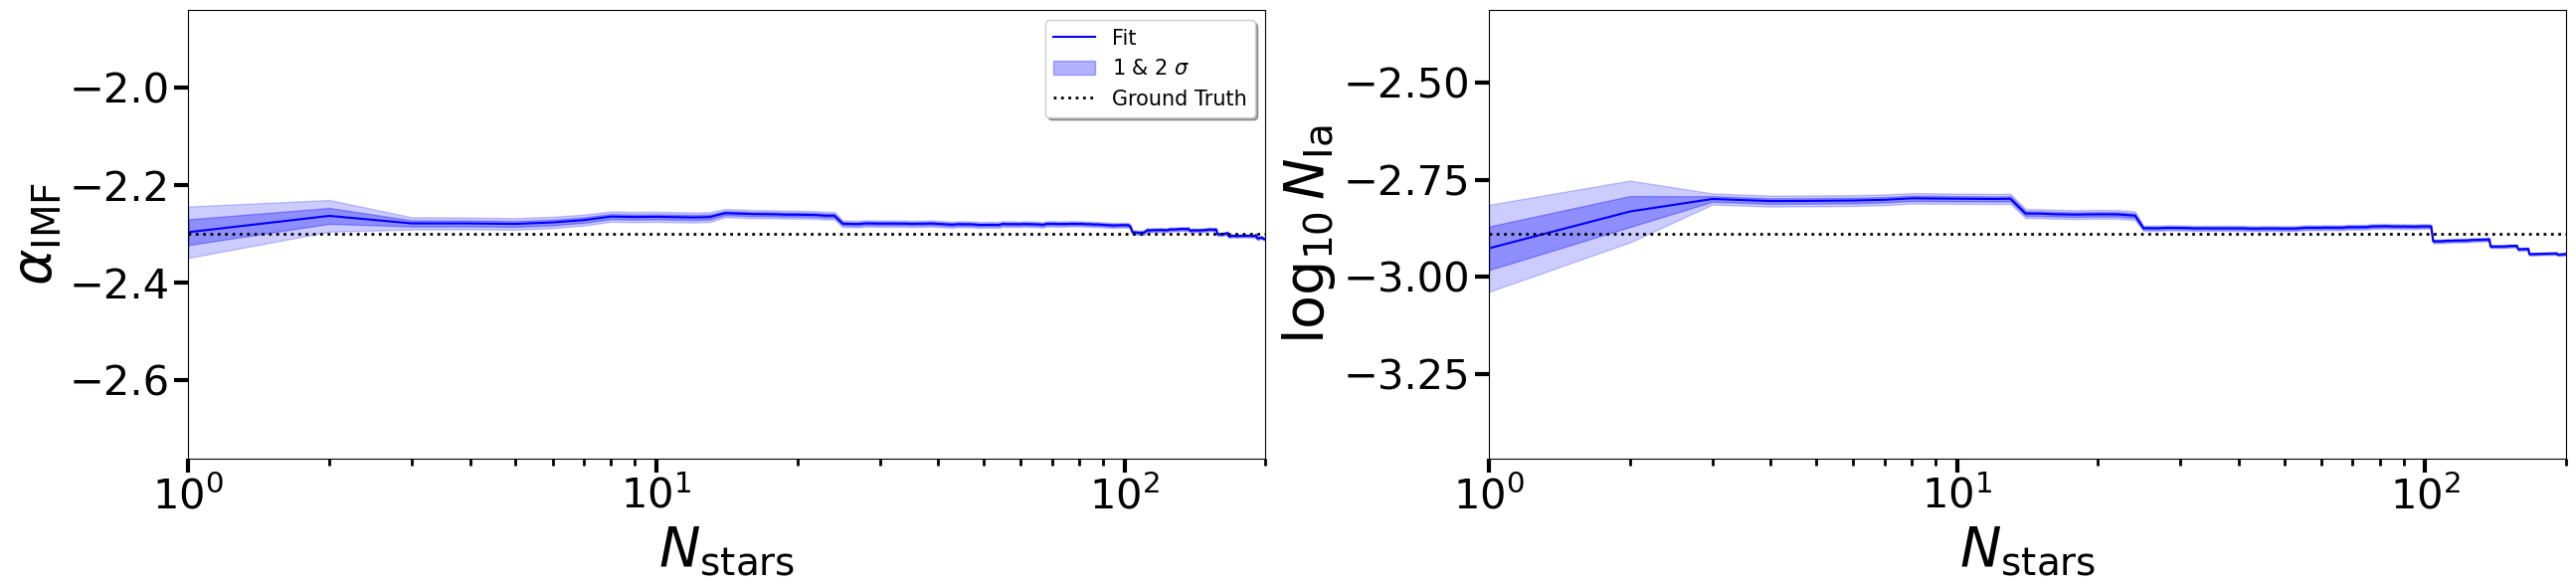

In [9]:
stars = np.arange(1,len(alpha_IMF_obs)+1)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params, "CHEMPY TNG yields N_star", stars)